In [1]:
from koopman_probabilistic import *
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from scipy.stats import norm, skewnorm

In [2]:
import json

with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json") as f:
    all_data = json.loads(f.read())
    
# x = np.transpose(np.array([all_data["ISONE CA"]["DEMAND"], all_data["ISONE CA"]["DewPnt"], all_data["ISONE CA"]["DryBulb"]], dtype=np.float64))
all_zones = []
all_temps = []
# # ['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']
# for zone in all_data.keys():
#     all_zones.append(all_data[zone]["DEMAND"])
#     all_temps.append(all_data[zone]["DryBulb"])
# x = np.transpose(np.array(all_zones, dtype=np.float64))
x = np.transpose(np.array([all_data["VT"]["DEMAND"]], dtype=np.float64))

In [3]:
x_original = x
mean = np.mean(x, axis=0)
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = (x - np.matlib.repmat(mean, x.shape[0], 1)) / np.matlib.repmat(rnge, x.shape[0], 1)
print("x", x.shape)

x (96408, 1)


In [4]:
data_name = "VT"

train_through = 365 * 24
train_start = -2 * 365 * 24
delay = 52 * 24
x = x[train_start:]
predict_through = train_through + 24 * 31 + delay  # 1.5 to 2 month gap, then 1 month forecast
x = x[:predict_through]
xt = x[:train_through, :]

num_freqs = [6, 6, 6]
num_fourier = 4
mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
alpha_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}alpha.npy"
print("x", x.shape)
print("xt", xt.shape)

x (10752, 1)
xt (8760, 1)


In [5]:
model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=512)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [17]:
k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.25])

tensor([0.2618, 0.0374, 0.0086, 0.0007])

In [46]:
# TODO: change koopman to weight recent ones more
k.fit(xt, iterations=500, interval=10, verbose=True, cutoff=0, weight_decay=1e-10000, lr_theta=1e-4, lr_omega=1e-10, num_slices=None);

Iteration  0
tensor([  24.0000,  168.0000,  730.4999, 8823.8877,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8837.8936,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4268,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8823.8877,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8837.8936,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4268,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3857322444843283
Iteration  1
tensor([  24.0000,  168.0000,  730.4999, 8823.8877,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8837.8936,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4268,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8823.8877,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8837.8936,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4268,   13.3351

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8823.9414,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8837.9902,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4277,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3873901988221033
Iteration  16
tensor([  24.0000,  168.0000,  730.4999, 8823.9414,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8837.9902,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4277,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8823.9941,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8838.0762,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4268,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3875040596269275
Iteration  17
tensor([  24.0000,  168.0000,  730.4999, 8823.9941,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8838.0762,   21.0679,   19.2112,
 

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8825.0596,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8839.8252,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4346,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3893220990366741
Iteration  32
tensor([  24.0000,  168.0000,  730.4999, 8825.0596,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8839.8252,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4346,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8825.1318,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8839.9443,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4346,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3894446324058172
Iteration  33
tensor([  24.0000,  168.0000,  730.4999, 8825.1318,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8839.9443,   21.0679,   19.2112,
 

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8826.2119,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8841.7373,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4346,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3912888420995306
Iteration  48
tensor([  24.0000,  168.0000,  730.4999, 8826.2119,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8841.7373,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4346,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8826.2842,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8841.8574,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4346,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3914121465848477
Iteration  49
tensor([  24.0000,  168.0000,  730.4999, 8826.2842,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8841.8574,   21.0679,   19.2112,
 

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8827.3584,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8843.6768,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4346,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3932613001706013
Iteration  64
tensor([  24.0000,  168.0000,  730.4999, 8827.3584,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8843.6768,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4346,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8827.4297,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8843.7988,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4346,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3933858155761207
Iteration  65
tensor([  24.0000,  168.0000,  730.4999, 8827.4297,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8843.7988,   21.0679,   19.2112,
 

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8828.4805,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8845.6357,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4346,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3952367882104708
Iteration  80
tensor([  24.0000,  168.0000,  730.4999, 8828.4805,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8845.6357,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4346,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8828.5479,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8845.7607,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4336,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.395360440346651
Iteration  81
tensor([  24.0000,  168.0000,  730.4999, 8828.5479,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8845.7607,   21.0679,   19.2112,
  

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8829.5664,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8847.6309,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4229,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.397214470054202
Iteration  96
tensor([  24.0000,  168.0000,  730.4999, 8829.5664,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8847.6309,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4229,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8829.6348,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8847.7578,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4219,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3973382207694642
Iteration  97
tensor([  24.0000,  168.0000,  730.4999, 8829.6348,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8847.7578,   21.0679,   19.2112,
  

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8830.6455,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8849.6885,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4111,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3991972824922405
Iteration  112
tensor([  24.0000,  168.0000,  730.4999, 8830.6455,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8849.6885,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4111,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8830.7109,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8849.8184,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.4102,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.3993215974564752
Iteration  113
tensor([  24.0000,  168.0000,  730.4999, 8830.7109,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8849.8184,   21.0679,   19.2112,

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8831.6924,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8851.7412,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.3887,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4011836968859233
Iteration  128
tensor([  24.0000,  168.0000,  730.4999, 8831.6924,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8851.7412,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.3887,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8831.7568,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8851.8691,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.3867,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4013075716161865
Iteration  129
tensor([  24.0000,  168.0000,  730.4999, 8831.7568,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8851.8691,   21.0679,   19.2112,

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8832.7012,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8853.8096,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.3545,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4031692101049895
Iteration  144
tensor([  24.0000,  168.0000,  730.4999, 8832.7012,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8853.8096,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.3545,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8832.7637,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8853.9395,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.3525,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4032948723806724
Iteration  145
tensor([  24.0000,  168.0000,  730.4999, 8832.7637,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8853.9395,   21.0679,   19.2112,

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8833.7012,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8855.8896,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.3203,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4051576977714073
Iteration  160
tensor([  24.0000,  168.0000,  730.4999, 8833.7012,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8855.8896,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.3203,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8833.7656,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8856.0205,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.3184,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4052825510153728
Iteration  161
tensor([  24.0000,  168.0000,  730.4999, 8833.7656,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8856.0205,   21.0679,   19.2112,

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8834.7207,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8857.9629,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.2861,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4071452037757615
Iteration  176
tensor([  24.0000,  168.0000,  730.4999, 8834.7207,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8857.9629,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.2861,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8834.7842,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8858.0918,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.2842,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.40726879211467
Iteration  177
tensor([  24.0000,  168.0000,  730.4999, 8834.7842,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8858.0918,   21.0679,   19.2112,
 

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8835.7236,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8860.0459,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.2520,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4091311123511938
Iteration  192
tensor([  24.0000,  168.0000,  730.4999, 8835.7236,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8860.0459,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.2520,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8835.7852,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8860.1777,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.2500,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4092549362398528
Iteration  193
tensor([  24.0000,  168.0000,  730.4999, 8835.7852,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8860.1777,   21.0679,   19.2112,

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8836.7041,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8862.1611,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.2100,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4111214631113118
Iteration  208
tensor([  24.0000,  168.0000,  730.4999, 8836.7041,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8862.1611,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.2100,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8836.7646,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8862.2939,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.2061,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4112457531980462
Iteration  209
tensor([  24.0000,  168.0000,  730.4999, 8836.7646,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8862.2939,   21.0679,   19.2112,

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8837.6689,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8864.2842,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.1523,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.413111685161456
Iteration  224
tensor([  24.0000,  168.0000,  730.4999, 8837.6689,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8864.2842,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.1523,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8837.7295,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8864.4170,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.1494,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4132362953656348
Iteration  225
tensor([  24.0000,  168.0000,  730.4999, 8837.7295,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8864.4170,   21.0679,   19.2112,


Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8838.6475,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8866.4004,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.0830,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4151022961902302
Iteration  240
tensor([  24.0000,  168.0000,  730.4999, 8838.6475,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8866.4004,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.0830,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8838.7080,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8866.5322,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.0781,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.415226675765126
Iteration  241
tensor([  24.0000,  168.0000,  730.4999, 8838.7080,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8866.5322,   21.0679,   19.2112,


Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8839.5986,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8868.5342,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.0049,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.417094699311131
Iteration  256
tensor([  24.0000,  168.0000,  730.4999, 8839.5986,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8868.5342,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.0049,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8839.6562,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8868.6680,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8765.0010,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4172182482203848
Iteration  257
tensor([  24.0000,  168.0000,  730.4999, 8839.6562,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8868.6680,   21.0679,   19.2112,


Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8840.5244,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8870.7090,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.9365,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4190877195517813
Iteration  272
tensor([  24.0000,  168.0000,  730.4999, 8840.5244,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8870.7090,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.9365,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8840.5820,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8870.8467,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.9326,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.419213034227925
Iteration  273
tensor([  24.0000,  168.0000,  730.4999, 8840.5820,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8870.8467,   21.0679,   19.2112,


Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8841.4199,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8872.9238,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.8594,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4210892521679004
Iteration  288
tensor([  24.0000,  168.0000,  730.4999, 8841.4199,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8872.9238,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.8594,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8841.4756,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8873.0615,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.8545,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.421215297634885
Iteration  289
tensor([  24.0000,  168.0000,  730.4999, 8841.4756,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8873.0615,   21.0679,   19.2112,


Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8842.2949,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8875.1426,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.7793,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4230922796292793
Iteration  304
tensor([  24.0000,  168.0000,  730.4999, 8842.2949,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8875.1426,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.7793,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8842.3486,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8875.2822,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.7744,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.423217839845507
Iteration  305
tensor([  24.0000,  168.0000,  730.4999, 8842.3486,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8875.2822,   21.0679,   19.2112,


Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8843.1621,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8877.3799,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.6982,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4250983511848148
Iteration  320
tensor([  24.0000,  168.0000,  730.4999, 8843.1621,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8877.3799,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.6982,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8843.2168,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8877.5195,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.6924,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.425222544033691
Iteration  321
tensor([  24.0000,  168.0000,  730.4999, 8843.2168,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8877.5195,   21.0679,   19.2112,


Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8844.0117,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8879.6318,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.6074,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.42711312317342
Iteration  336
tensor([  24.0000,  168.0000,  730.4999, 8844.0117,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8879.6318,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.6074,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8844.0635,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8879.7744,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.6016,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.427238926613802
Iteration  337
tensor([  24.0000,  168.0000,  730.4999, 8844.0635,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8879.7744,   21.0679,   19.2112,
  

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8844.8252,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8881.9180,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.5156,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4291335060754606
Iteration  352
tensor([  24.0000,  168.0000,  730.4999, 8844.8252,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8881.9180,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.5156,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8844.8779,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8882.0596,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.5098,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4292583320699455
Iteration  353
tensor([  24.0000,  168.0000,  730.4999, 8844.8779,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8882.0596,   21.0679,   19.2112,

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8845.6494,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8884.2139,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.4199,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4311570877818884
Iteration  368
tensor([  24.0000,  168.0000,  730.4999, 8845.6494,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8884.2139,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.4199,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8845.7002,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8884.3564,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.4131,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4312836623649956
Iteration  369
tensor([  24.0000,  168.0000,  730.4999, 8845.7002,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8884.3564,   21.0679,   19.2112,

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8846.4561,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8886.5117,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.3320,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4331893935828177
Iteration  384
tensor([  24.0000,  168.0000,  730.4999, 8846.4561,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8886.5117,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.3320,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8846.5039,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8886.6553,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.3262,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.433318184008312
Iteration  385
tensor([  24.0000,  168.0000,  730.4999, 8846.5039,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8886.6553,   21.0679,   19.2112,


Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8847.1875,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8888.8203,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.2520,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.435235585515149
Iteration  400
tensor([  24.0000,  168.0000,  730.4999, 8847.1875,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8888.8203,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.2520,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8847.2324,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8888.9648,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.2471,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.435357475151219
Iteration  401
tensor([  24.0000,  168.0000,  730.4999, 8847.2324,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8888.9648,   21.0679,   19.2112,
 

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8847.8818,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8891.1484,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.1729,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4372911388421163
Iteration  416
tensor([  24.0000,  168.0000,  730.4999, 8847.8818,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8891.1484,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.1729,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8847.9229,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8891.2939,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.1670,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4374171509482556
Iteration  417
tensor([  24.0000,  168.0000,  730.4999, 8847.9229,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8891.2939,   21.0679,   19.2112,

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8848.5498,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8893.5117,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.0928,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4393463045446242
Iteration  432
tensor([  24.0000,  168.0000,  730.4999, 8848.5498,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8893.5117,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.0928,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8848.5908,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8893.6621,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.0869,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4394854295234234
Iteration  433
tensor([  24.0000,  168.0000,  730.4999, 8848.5908,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8893.6621,   21.0679,   19.2112,

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8849.1807,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8895.9297,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.0117,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4414412775999637
Iteration  448
tensor([  24.0000,  168.0000,  730.4999, 8849.1807,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8895.9297,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.0117,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8849.2197,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8896.0820,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8764.0068,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4415660066801452
Iteration  449
tensor([  24.0000,  168.0000,  730.4999, 8849.2197,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8896.0820,   21.0679,   19.2112,

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8849.7930,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8898.3867,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8763.9209,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4435430099811035
Iteration  464
tensor([  24.0000,  168.0000,  730.4999, 8849.7930,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8898.3867,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8763.9209,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8849.8311,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8898.5410,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8763.9150,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4436730310696693
Iteration  465
tensor([  24.0000,  168.0000,  730.4999, 8849.8311,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8898.5410,   21.0679,   19.2112,

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8850.3711,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8900.8486,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8763.8398,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4456623069020813
Iteration  480
tensor([  24.0000,  168.0000,  730.4999, 8850.3711,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8900.8486,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8763.8398,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8850.4062,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8901.0039,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8763.8350,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.445788234333308
Iteration  481
tensor([  24.0000,  168.0000,  730.4999, 8850.4062,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8901.0039,   21.0679,   19.2112,


Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8850.9746,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8903.3340,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8763.7715,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.447825679448084
Iteration  496
tensor([  24.0000,  168.0000,  730.4999, 8850.9746,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8903.3340,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8763.7715,   13.3351,   12.5664])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8851.0127,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8903.4912,   21.0679,   19.2112,
          24.0000,  168.0000,  730.4999, 8763.7676,   13.3351,   12.5664],
       grad_fn=<MulBackward0>)
Loss:  -1.4479438851966142
Iteration  497
tensor([  24.0000,  168.0000,  730.4999, 8851.0127,   50.1475,   40.7688,
          24.0000,  168.0000,  730.4999, 8903.4912,   21.0679,   19.2112,


In [44]:
mu_hat, sigma_hat, a_hat = k.predict(predict_through)
np.save(mu_file, mu_hat)
np.save(sigma_file, sigma_hat)
np.save(alpha_file, a_hat)

<IPython.core.display.Javascript object>


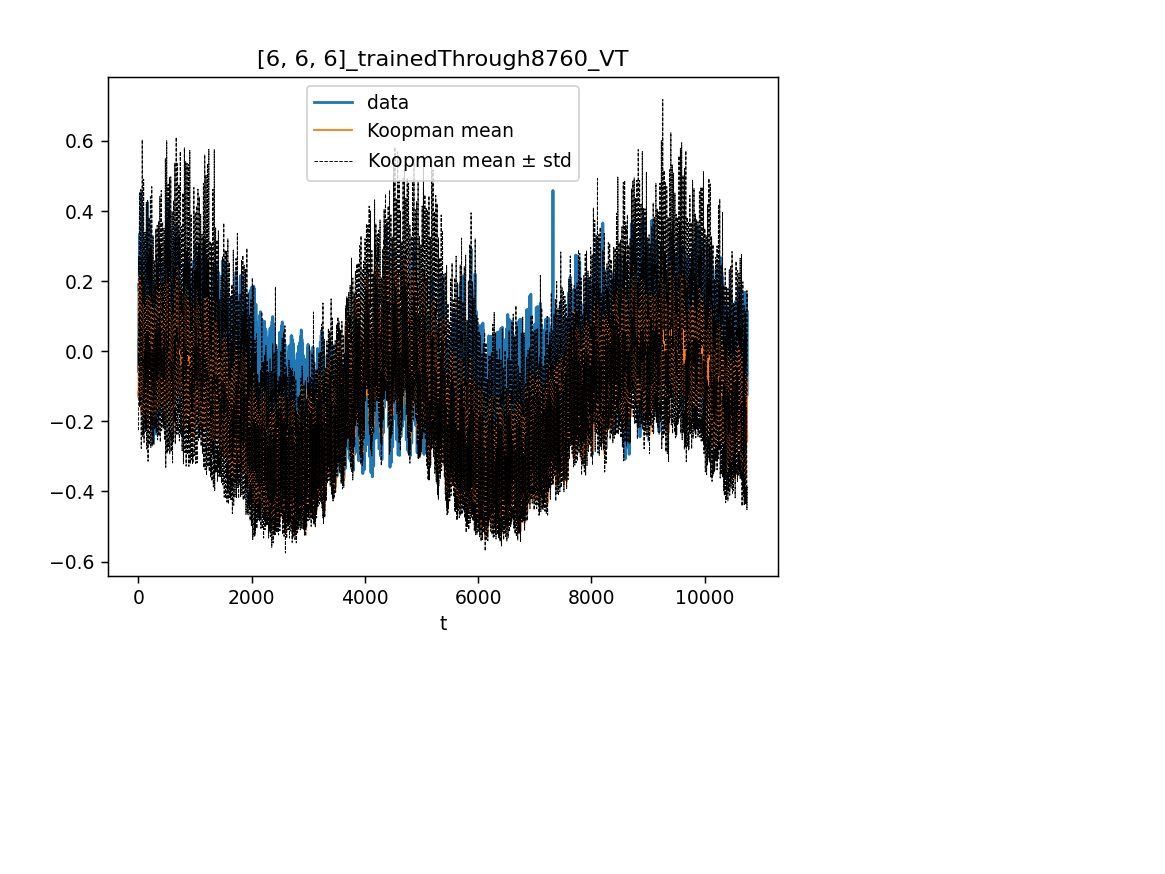

In [45]:
%matplotlib notebook

mean_hat = model.mean([mu_hat, sigma_hat, a_hat])
std_hat = model.std([mu_hat, sigma_hat, a_hat])
for dim in range(xt.shape[1]):
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
#     plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
#     plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    # plt.plot(mu_vec[slc:], label="real mu")
    # plt.plot(mu_hat[slc:, 0], label="koopman mu")
    # plt.legend()
    # plt.show()
    #
    # plt.plot(sigma_vec[slc:], label="real sigma")
    #     plt.plot(3*sigma_hat[:, dim], label="koopman $3\sigma$", linewidth=0.7)
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [37]:
print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))

actual overall mean: 0  predicted mean: -0.02341698


In [38]:
"mean of a_hat", np.mean(a_hat)

('mean of a_hat', 2.5455065)

In [39]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

In [40]:
z_scores = ((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
# z_scores = ((x[train_through:predict_through] - mean_hat[train_through:]) / std_hat[train_through:])[:8760, 0]
# z_scores /= np.std(z_scores)
z_hist, bin_edges = np.histogram(z_scores, bins=40, density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2

In [41]:
print(np.std(z_scores))
np.mean(z_scores)

1.7361706377788237


-0.5020617047434259

<IPython.core.display.Javascript object>


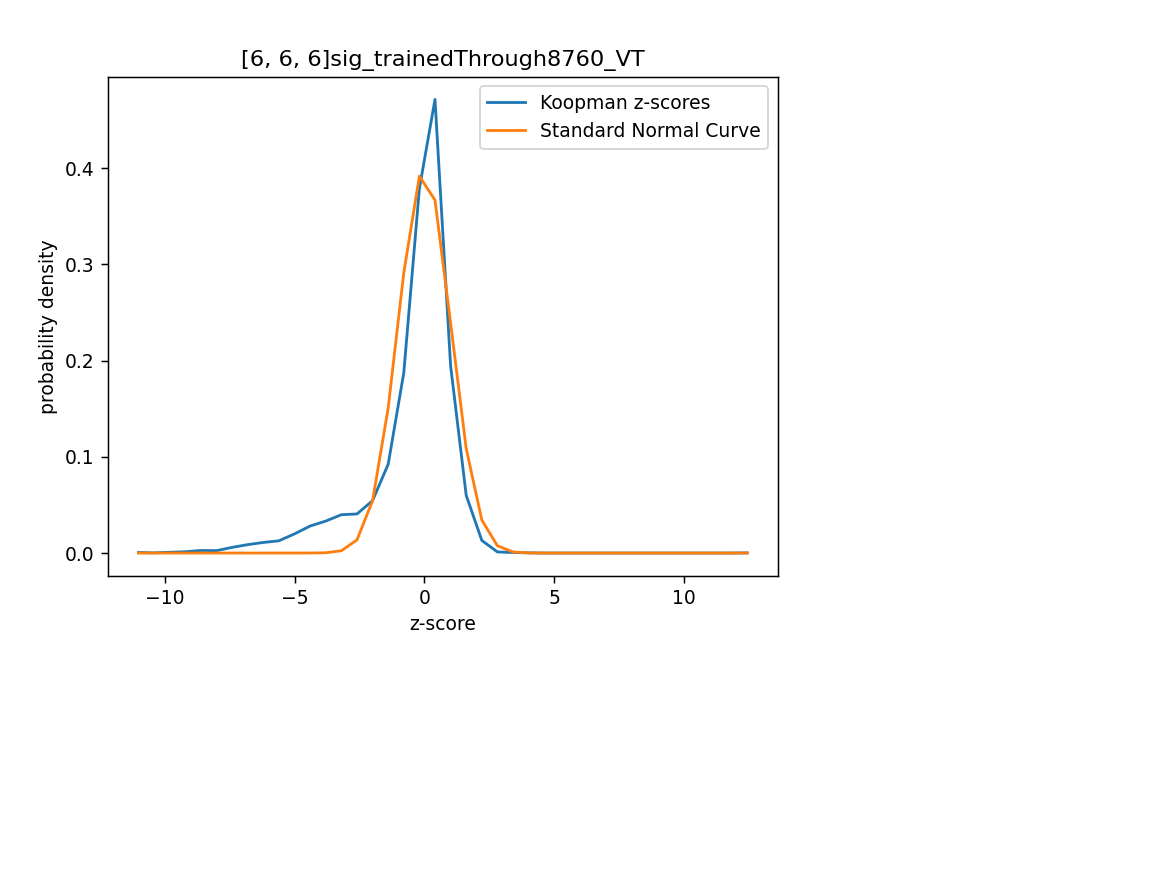

In [42]:
plt.figure()
plt.plot(z_axis, z_hist, label="Koopman z-scores")
plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
plt.title(f"{num_freqs}sig_trainedThrough{train_through}_" + data_name)
plt.xlabel("z-score")
plt.ylabel("probability density")
plt.legend()

# Pinball Loss

In [54]:
def pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

<IPython.core.display.Javascript object>


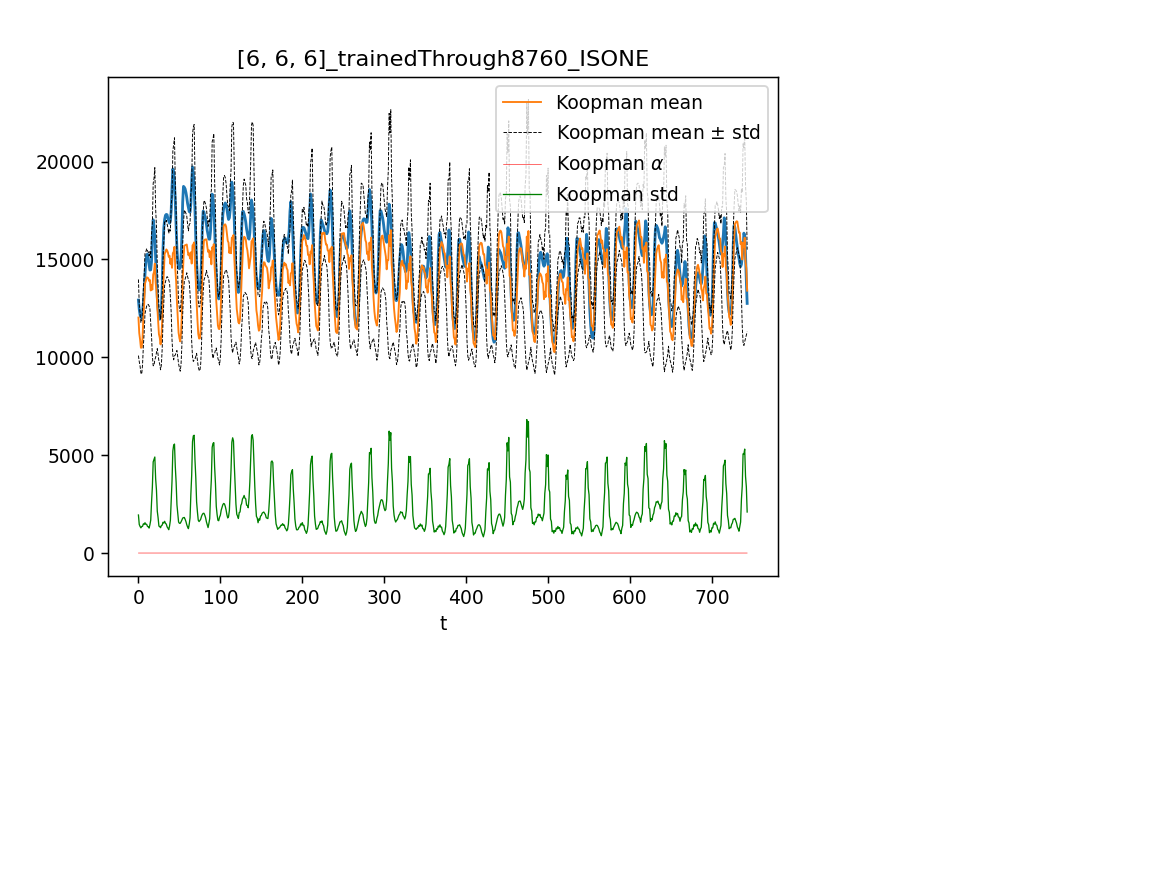

In [55]:
test_start = train_through + delay
sigh, ah =  sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
delta = ah / (1 + ah ** 2) ** 0.5
muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
sigh = sigh * rnge
mean_hat = model.mean([muh, sigh, ah])
std_hat = model.std([muh, sigh, ah])

plt.figure()
plt.plot(x_original[train_start:][test_start: predict_through])
plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
plt.xlabel("t")
plt.legend()
plt.show()

In [56]:
loss = pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)
print(loss)

[480.27261224]


In [57]:
# 1 - loss / 655  # isone +28%
# 1 - loss / 30.95  # VT +30%
# 1 - loss / 61.16  # ME +22%
# 1 - loss / 42.43  # RI -1%
# 1 - loss / 78.1  # SEMASS +15%
# 1 - loss / 128.2  # NEMASSBOST -10%
# 1 - loss / 93  # WCMASS -18%
# 1 - loss / 164.3  # CT -8%
# 1 - loss / 73.34  # NH 14%

# with 52 day gap between training and testing
# 1 - loss / 84.2  # WCMASS +25%
# 1 - loss / 122.8  # NEMASSBOST 39.4%
1 - loss / 596  # ISONE 19.4%

array([0.19417347])

In [17]:
# Construct pdf quantiles
# sigma = 1 * np.cos(2 * np.pi / 36 * np.arange(5000) + 1.5) + 4

num_quantiles = 100
domain = [min(mu_hat[:,0] - 2.5*sigma_hat[:, 0]), max(mu_hat[:,0] + 2.5*sigma_hat[:, 0])]
x_axis = np.linspace(domain[0], domain[1], num_quantiles)

In [18]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors

In [19]:
fig = plt.figure()
ax = fig.gca(projection='3d')

tmin = 21000
tmax = 21030
tstep = 2
ts = range(tmin, tmax, tstep)
plt.plot(mu_hat[tmin:tmax:tstep, 0], ts, np.zeros(len(ts)))
ax.scatter(x[tmin:tmax:tstep, 0], ts, np.zeros(len(ts)))

for i, t in enumerate(ts):
    z = normal_pdf(mu_hat[t], sigma_hat[t], x_axis)
    plt.plot(x_axis, t*np.ones(num_quantiles), z, color=(0.3, 0.3, 0.3 + 0.03*i))

plt.xlabel("x")
plt.ylabel("t")
ax.set_zlabel("probability density")


plt.show()

<IPython.core.display.Javascript object>

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (15,) and requested shape (0,)

In [29]:
import os

folder = ".\\forecasts\GEFComFirstQualTest"
a_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]alpha.npy"))
mu_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]mu.npy"))
sigma_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]sigma.npy"))

In [22]:
a = torch.tensor([0, 1])

In [25]:
a = a[:, None]

In [27]:
torch.repeat_interleave(a, 3, 1)

tensor([[0, 0, 0],
        [1, 1, 1]])

In [26]:
a.shape

torch.Size([2, 1])